<a href="https://colab.research.google.com/github/ematala/satellite-segmentation/blob/main/AlternativeModels_Lukas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import os
import datetime
import sklearn
import matplotlib.pyplot as plt
import math
from google.colab import drive

In [15]:
drive.mount('/content/drive')
data = np.load('/content/drive/MyDrive/Colab Notebooks/Data/train.npz')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# separate bands and labels:
train_data = data['bands']
labels = data['lulc']

In [17]:
train_data.shape

(10000, 12, 33, 33, 6)

 Data visualization


In [18]:
# add class labels manually
classes = np.array(['No Data', 'Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Tundra', 'Artificial Surface', 'Bareland', 'Snow and Ice'])

In [19]:
np.histogram(labels, bins=list(range(len(classes) + 1)))

(array([1308,  238, 5796, 1125,  770,   58,    0,    0,  217,  488,    0]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]))

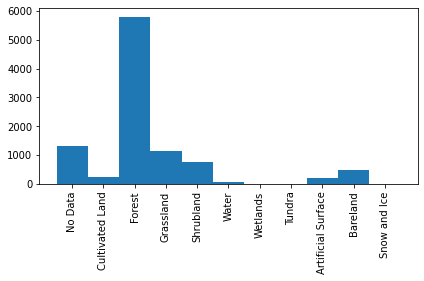

In [20]:
plt.hist(labels, bins=list(range(len(classes) + 1)))
plt.xticks(ticks=list(map(lambda x: x+0.5, list(range(len(classes))))), labels=classes, rotation=90)
plt.tight_layout()
plt.show()

## First experiment

In [ ]:
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPool2D, ReLU, BatchNormalization, GlobalAveragePooling2D, Dropout

firstModel = keras.Sequential()

firstModel.add(keras.layers.Conv3D(64, 3, input_shape=(12,33,33, 6), padding="same", activation="relu"))
firstModel.add(keras.layers.Conv3D(64, 3, padding="same", activation="relu"))
firstModel.add(keras.layers.MaxPool3D())
firstModel.add(keras.layers.Conv3D(128, 3, padding="same", activation="relu"))
firstModel.add(keras.layers.Conv3D(128, 3, padding="same", activation="relu"))
firstModel.add(keras.layers.MaxPool3D())
firstModel.add(keras.layers.Conv3D(256, 3, padding="same", activation="relu"))
firstModel.add(keras.layers.Conv3D(256, 3, padding="same", activation="relu"))
firstModel.add(keras.layers.Conv3D(256, 3, padding="same", activation="relu"))
firstModel.add(keras.layers.MaxPool3D())
firstModel.add(keras.layers.Conv3D(512, 3, padding="same", activation="relu"))
firstModel.add(keras.layers.Conv3D(512, 3, padding="same", activation="relu"))
firstModel.add(keras.layers.Conv3D(512, 3, padding="same", activation="relu"))
firstModel.add(keras.layers.MaxPool3D(pool_size=(1,4,4)))
firstModel.add(keras.layers.Dense(4096, activation="relu"))
firstModel.add(keras.layers.Dense(4096, activation="relu"))
firstModel.add(keras.layers.Dense(1000, activation="relu"))
firstModel.add(keras.layers.Dense(11, activation="softmax"))

firstModel.compile(
  'Adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)

firstModel.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_13 (Conv3D)           (None, 12, 33, 33, 64)    10432     
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 12, 33, 33, 64)    110656    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 6, 16, 16, 64)     0         
_________________________________________________________________
conv3d_15 (Conv3D)           (None, 6, 16, 16, 128)    221312    
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 6, 16, 16, 128)    442496    
_________________________________________________________________
max_pooling3d_6 (MaxPooling3 (None, 3, 8, 8, 128)      0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 3, 8, 8, 256)     

In [ ]:
history = firstModel.fit(train_data[:,2,:,:,:], labels, batch_size=32, validation_split=0.1, validation_batch_size=8, epochs=5)

Epoch 1/5
282/282 [==============================] - 99s 352ms/step - loss: 1.3781 - accuracy: 0.5843 - val_loss: 1.3982 - val_accuracy: 0.5380
Epoch 2/5
282/282 [==============================] - 100s 353ms/step - loss: 1.3769 - accuracy: 0.5843 - val_loss: 1.3970 - val_accuracy: 0.5380
Epoch 3/5
282/282 [==============================] - 95s 337ms/step - loss: 1.3785 - accuracy: 0.5841 - val_loss: 1.3991 - val_accuracy: 0.5380
Epoch 4/5
282/282 [==============================] - 100s 353ms/step - loss: 1.3773 - accuracy: 0.5844 - val_loss: 1.4040 - val_accuracy: 0.5380
Epoch 5/5
282/282 [==============================] - 100s 353ms/step - loss: 1.3774 - accuracy: 0.5841 - val_loss: 1.3830 - val_accuracy: 0.5380


In [ ]:
# This model is similar to the VGGNets
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPool2D, ReLU, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras import models, layers

model = models.Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=None, input_shape=(33,33,6)))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation=None))
model.add(layers.BatchNormalization())
model.add(layers.ReLU()) 
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=11, activation = 'softmax'))
model.summary()

model.compile(
  'Adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 33, 33, 64)        3520      
_________________________________________________________________
batch_normalization_14 (Batc (None, 33, 33, 64)        256       
_________________________________________________________________
re_lu_14 (ReLU)              (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 33, 33, 64)        36928     
_________________________________________________________________
batch_normalization_15 (Batc (None, 33, 33, 64)        256       
_________________________________________________________________
re_lu_15 (ReLU)              (None, 33, 33, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 64)       

In [ ]:
history2 = model.fit(train_data[:,2,:,:,:], labels, batch_size=32, validation_split=0.1, validation_batch_size=8, epochs=100)

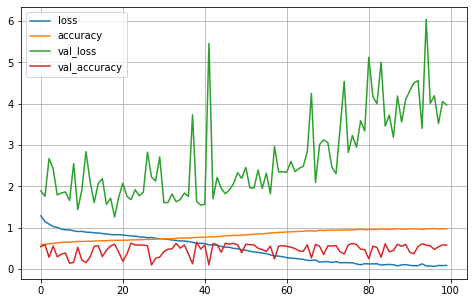

In [ ]:
import pandas as pd

df = pd.DataFrame(history2.history).plot(figsize=(8, 5))
df.plot(figsize=(8,5))
plt.grid(True)
plt.show()

In [ ]:
  import sys
  np.set_printoptions(threshold=sys.maxsize)

In [ ]:
predictions = model.predict(train_data[:,2,:,:,:]).reshape((10000,11))

In [ ]:
indexes = tf.argmax(predictions, axis=1)
print(indexes) # prints [0 2 2]

In [ ]:
# plot histogram:
np.histogram(indexes, bins=list(range(len(classes))))

(array([ 254,    1, 8791,  139,  392,    4,    0,    0,    0,  419]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]))

In [ ]:
from matplotlib import pyplot
pyplot.imshow(train_data[1,:,:,0:3])
# show the figure
pyplot.show()

## Third experiment

In [24]:
# This model is similar to the VGGNets
from tensorflow.keras.layers import InputLayer, Dense, Flatten, Conv2D, MaxPool2D, MaxPool3D, ReLU, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras import models, layers

model3 = models.Sequential()

model3.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=None, input_shape=(33,33,6)))
model3.add(layers.BatchNormalization())
model3.add(layers.ReLU()) 
model3.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation=None))
model3.add(layers.BatchNormalization())
model3.add(layers.ReLU()) 
model3.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model3.add(layers.GlobalAveragePooling2D())

model3.add(layers.Dropout(0.4))
model3.add(layers.Dense(units=11, activation = 'softmax'))
model3.summary()

model3.compile(
  'Adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'],
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 33, 33, 64)        3520      
_________________________________________________________________
batch_normalization_8 (Batch (None, 33, 33, 64)        256       
_________________________________________________________________
re_lu_8 (ReLU)               (None, 33, 33, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 33, 33, 64)        36928     
_________________________________________________________________
batch_normalization_9 (Batch (None, 33, 33, 64)        256       
_________________________________________________________________
re_lu_9 (ReLU)               (None, 33, 33, 64)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 64)       

In [25]:
history3 = model3.fit(train_data[:,6,:,:,:], labels, batch_size=32, validation_split=0.1, validation_batch_size=8, epochs=100)

Epoch 1/100
282/282 [==============================] - 34s 9ms/step - loss: 1.2819 - accuracy: 0.5917 - val_loss: 1.4562 - val_accuracy: 0.5370
Epoch 2/100
282/282 [==============================] - 2s 7ms/step - loss: 1.1152 - accuracy: 0.6150 - val_loss: 1.2381 - val_accuracy: 0.6150
Epoch 3/100
282/282 [==============================] - 2s 7ms/step - loss: 1.0663 - accuracy: 0.6246 - val_loss: 1.5144 - val_accuracy: 0.5000
Epoch 4/100
282/282 [==============================] - 2s 7ms/step - loss: 1.0336 - accuracy: 0.6306 - val_loss: 1.2258 - val_accuracy: 0.5970
Epoch 5/100
282/282 [==============================] - 2s 8ms/step - loss: 1.0171 - accuracy: 0.6371 - val_loss: 2.7932 - val_accuracy: 0.1900
Epoch 6/100
282/282 [==============================] - 2s 7ms/step - loss: 0.9968 - accuracy: 0.6400 - val_loss: 1.4903 - val_accuracy: 0.1710
Epoch 7/100
282/282 [==============================] - 2s 7ms/step - loss: 0.9821 - accuracy: 0.6450 - val_loss: 1.4323 - val_accuracy: 0.474

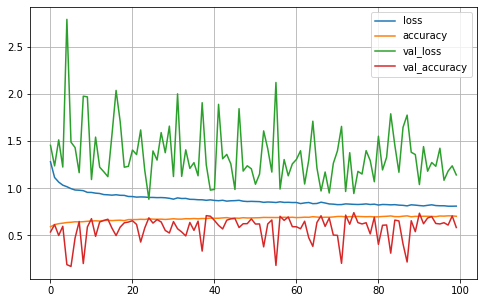

In [26]:
import pandas as pd

df = pd.DataFrame(history3.history).plot(figsize=(8, 5))
df.plot(figsize=(8,5))
plt.grid(True)
plt.show()